# TD3: Generative Adversarial Networks.

* Dans ce TP nous allons chercher à générer des séries temporelles à partir de modéles Generatifs et plus precisements des GAN's dans notre cas.On notera que d'autres modéles comme des Autoencorders ou Variationnal Autoencoders sont aussi des modéles largements utilisés.

In [ ]:
# Import des librairies
!pip3 install --upgrade tensorflow-gpu
import tensorflow as tf
tf.test.gpu_device_name()
!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from numpy import hstack ,zeros , ones
from numpy.random import rand ,randn
from keras.layers import Dense , Dropout
from sklearn.utils import shuffle


     |████████████████████████████████| 394.3MB 41kB/s 
     |████████████████████████████████| 5.5MB 23.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=f01bcadef8cbad6b076987844db9b834a7cec41d9d7c6e7ee717b8dfe689e2f9
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
TICKER = "^GSPC"
Stock = yf.download(TICKER) ; Stock = Stock.dropna()
asset_log_returns = pd.DataFrame(data = np.log(Stock['Adj Close']).diff().dropna())
Stock = Stock.drop(Stock.index[0], axis=0) ; 
Stock['returns'] = asset_log_returns.values
Stock['vol'] = np.sqrt(Stock['returns'].rolling(20).var())
Stock = Stock.dropna();
Stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,returns,vol
Date,,,,,,,,
1928-01-30,17.490000,17.490000,17.490000,17.490000,17.490000,0,-0.011370,0.007777
1928-01-31,17.570000,17.570000,17.570000,17.570000,17.570000,0,0.004564,0.007736
1928-02-01,17.530001,17.530001,17.530001,17.530001,17.530001,0,-0.002279,0.007736
1928-02-02,17.629999,17.629999,17.629999,17.629999,17.629999,0,0.005688,0.007544
1928-02-03,17.400000,17.400000,17.400000,17.400000,17.400000,0,-0.013132,0.007963
...,...,...,...,...,...,...,...,...
2021-03-26,3917.120117,3978.189941,3917.120117,3974.540039,3974.540039,5467850000,0.016494,0.011099
2021-03-29,3969.310059,3981.830078,3943.250000,3971.090088,3971.090088,4619840000,-0.000868,0.009897
2021-03-30,3963.340088,3968.010010,3944.350098,3958.550049,3958.550049,4103570000,-0.003163,0.009721


In [ ]:
data = Stock['returns'].values

> On a chargé les données historiques du S&P500 sur tout la profondeur possible.On dispose donc des cotations journalieres ainsi que des indicateurs journalières depuis le 30 janvier 1928 jusqu'au 1 avril 2021.

## I : Reseaux Denses Naifs:





Nous implementatons un GAN en s'inspirant fortement de la structure trouvée sur MachineLearning Mastery. Nous fixons les learnings rate du ADAM pour le discriminateur et le generateur de maniere precise car le GAN est trés sensibles à ces hyperparametres.
On fixe le learning rate à 2e-4 pour le generateur et 1e-5 pour le discriminateur.

Si le discriminateur apprend trops vite alors il n'y a aucun espoir pour que le generateur apprenne quelque chose.
A contrario , si le learning rate est trops faible , les deux n'apprennent rien.



Nous allons énoncer ci dessous le principe générale d'un reseau GAN traditionnel: 

- Avec fonctions d'activations lineaires en sortie des les couches denses du generateur.

- Avec fontions d'activation lineaires pour les hidden layers du discriminateur et une fonction sigmoid pour la couche de sortie.  

- Durant l'entrainement du GAN , le discriminateur entraine le generateur à produire des echantillons qui ressemblent aux echantillons issues du dataset réel, tout ca à partir de bruit ( = generation de variables aleatoires suivant une loi uniforme ou normale) et le discriminateur est entrainé à distinguer les vrai samples des faux générés par le générateur.

- Chacun des reseaux cherche à minimiser sa propre fonction de coup et s'arrête une fois que l'équilibre de Nash est atteind c 'est à dire a partir du moment ou les deux reseaux ne peuvent plus continuer à s'améliorer.On peut se representer se point d'equilibre comme un point col ou selle.

On peut utlisé une version modifiée du GAN pour faire face aux effets de vanishing gradient et explosion de modes. L'utilisation d'une fonction de perte de "Wasserstein" permet de remedier partiellement au probleme que l'ont peut rencontrer sur un GAN classique. Il est aussi possible d'utiliser une version plus robuste du WGAn en introduisant une penalité sur le gradient: WGAN with gradient penalty (WGAN-GP) [1] ou  GAN with a gradient norm penalty.

Pour plus de details sur le WGAN-GP : 
- [1] Ishaan Gulrajani, Faruk Ahmed, Marin Arjovsky, Vincent Dumoulin, and Aaron Courville. Improved
Training of Wasserstein GANs. arXiv preprint arXiv:1704.00028, 2017


> Pour se Tp nous n'avons pas eu besoin d'avoir recours à des versions de GAN's plus robustes , nous avons donc implémentés un GAN traditionnel.

* $\textbf{Parametres GAN}$ : On utilise des tailles de series T = 200,  les Reals samples sont des series de 200 tirées du S&P500 chargé plus haut et les fakes sampples sont du bruit genéré aleatoirement et propagé à traver le générateur.Nous utilisons pour bruit un vecteur gaussien de taille D = 40 dont les variables aléatoires sont indépedantes d'ésperance nulle et de variance 1.
!
On travail sur des datasets d'entrainement de taille 2000 c est à dire 1000 échantillons Real et 1000 échantillons Fakes mélangés.

Les architectures du générateur et du discriminateur sont des architectures denses multicouches dont le biais est gardé par default à "True".

L'option "bias_check" nous permettra de verifier si en prenant un vecteur nul pour le bruit ,le generateur à appris du biais.

In [ ]:
#### Creations des fonctions qui nous permettent d'entrainer le GAN

INIT_LR = 1e-5

# generate n real samples with class labels
def generate_real_samples(n):
  train = [] ; serie_size = 200 ; 
  for i in range(n):
    train.append(data[i:i+serie_size])
  X = np.array(train)
  # generate class labels
  y = ones((n, 1))
  return X, y 

def generate_latent_points(latent_dim=40, n=1000,bias_check = False):
  if bias_check == True:
    x_input = np.zeros(latent_dim*n)
  else :
    x_input = np.random.normal(0, 1, latent_dim*n)
  x_input = x_input.reshape(n, latent_dim)
  return x_input  ## generate a X_input of dim 1000*10

def generate_fake_samples(generator, latent_dim=40, n=1000,bias_check = False):
  x_input = generate_latent_points(latent_dim, n,bias_check)
  X = generator.predict(x_input)
  y = np.zeros((n,1))
  return X, y  ##  X de dim 1000*100


def create_generator(latent_space_dim=40, n_outputs=200):
  activ = 'relu'
  model = Sequential()
  model.add(Dense(40, activation = 'linear',input_dim=latent_space_dim))
  model.add(Dropout(0.2))
  model.add(Dense(60, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(80, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(120, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(150, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(170, activation = activ))
  model.add(Dense(n_outputs, activation='linear'))
  return model

def create_discriminator(intput_size=200):
  activ = 'tanh'
  model = Sequential()
  model.add(Dense(150, activation= activ,input_dim = intput_size))
  model.add(Dropout(0.2))
  model.add(Dense(100, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation = activ))
  model.add(Dense(1, activation ='sigmoid'))
  ganDisc = Adam(lr=INIT_LR/2, beta_1=0.5) 
  model.compile(loss='binary_crossentropy',optimizer=ganDisc,metrics=['accuracy'])
  return model

def create_gan(generator, discriminator):

  print("[INFO] building GAN...")
  discriminator.trainable = False
  ganInput = Input(shape=(40,))
  ganOutput = discriminator(generator(ganInput))
  gan = Model(ganInput, ganOutput)

  ganOpt = Adam(lr=1e-5, beta_1=0.5) 
  gan.compile(loss='binary_crossentropy',optimizer=ganOpt)
  return gan

def summarize_performances(epoch, generator, discriminator,latent_dim=150, n_points=100):
  X_real, y_real = generate_real_samples(n_points)
  X_fake, y_fake = generate_fake_samples(generator,
  latent_dim, n_points,bias_check = False)
  # on concatene X_real et X_gan
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  _, acc = discriminator.evaluate(X_GAN, Y_GAN)
  print('Epoch {}, Acc {}'.format(epoch,acc))
  

In [ ]:
# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator()
# create the gan
gan_model = create_gan(generator, discriminator)


latent_dim=40 ; n_epochs = 500 ;  n_batch=256 ; n_eval=10

for i in tqdm(range(n_epochs)):
  X_real, y_real = generate_real_samples(n_batch//2)
  X_fake, y_fake = generate_fake_samples(generator,
  latent_dim, n_batch//2,bias_check = False)
  # on concatene X_real et X_gan
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  (X_GAN,Y_GAN) = shuffle(X_GAN,Y_GAN)
  discriminator.train_on_batch(X_GAN,Y_GAN)
  x_gan = generate_latent_points(latent_dim, n_batch,bias_check = False)
  y_gan = np.ones((n_batch, 1))
  gan_model.train_on_batch(x_gan, y_gan)

  if (i % n_eval == 0):
    summarize_performances(i, generator,
    discriminator, latent_dim)



[INFO] building GAN...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


7/7 [==============================] - 0s 2ms/step - loss: 0.6714 - accuracy: 0.7500
Epoch 0, Acc 0.75
7/7 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.7050
Epoch 10, Acc 0.7049999833106995
7/7 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.6600
Epoch 20, Acc 0.6600000262260437
7/7 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.6900
Epoch 30, Acc 0.6899999976158142
7/7 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5400
Epoch 40, Acc 0.5400000214576721
7/7 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.4800
Epoch 50, Acc 0.47999998927116394
7/7 [==============================] - 0s 2ms/step - loss: 0.7047 - accuracy: 0.4450
Epoch 60, Acc 0.4449999928474426
7/7 [==============================] - 0s 2ms/step - loss: 0.7089 - accuracy: 0.4200
Epoch 70, Acc 0.41999998688697815
7/7 [==============================] - 0s 2ms/step - loss: 0.7146 - a

* On génére 3 series de taille 200 a partir du générateur entrainé à l'etape précédente.

In [ ]:
X_test , _ = generate_fake_samples(generator,latent_dim=40,n=3)
data_plot = pd.DataFrame(data = { 'fake1' : X_test[0].cumsum().tolist() , 'fake2' : X_test[1].cumsum().tolist() , 'fake3' : X_test[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,0.014059,-0.032026,-0.082393
1,0.181446,0.231756,0.096473
2,0.256689,0.204780,0.142342
3,0.588540,0.613879,0.457099
4,0.492275,0.553231,0.463807
...,...,...,...
195,-0.435707,-0.871241,-0.707746
196,-0.622634,-1.105236,-0.778914
197,-0.671779,-1.260349,-0.875266
198,-0.653083,-1.287205,-0.922102


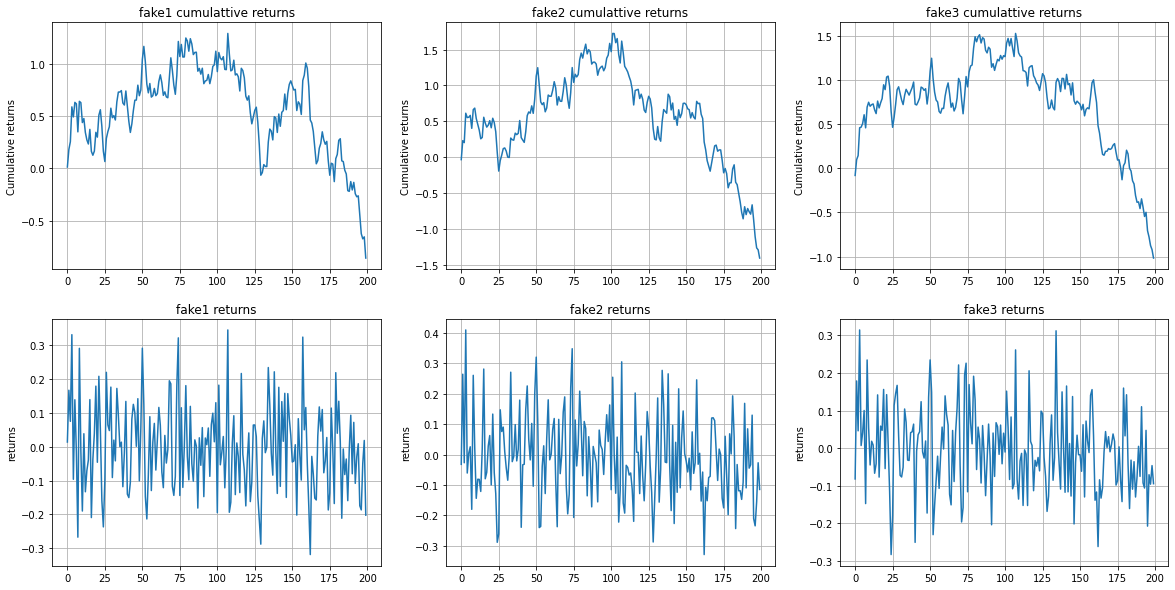

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

> On remarque que les series temporelles sont tres semblables. Elle sont proche sans etre identiques.

In [ ]:
X_test , _ = generate_fake_samples(generator,latent_dim=40,n=3,bias_check=True)
data_plot = pd.DataFrame(data = { 'fake1' : X_test[0].cumsum().tolist() , 'fake2' : X_test[1].cumsum().tolist() , 'fake3' : X_test[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,0.001574,0.001574,0.001574
1,0.020463,0.020463,0.020463
2,0.034281,0.034281,0.034281
3,0.050706,0.050706,0.050706
4,0.047692,0.047692,0.047692
...,...,...,...
195,0.109576,0.109576,0.109576
196,0.094690,0.094690,0.094690
197,0.106108,0.106108,0.106108
198,0.113410,0.113410,0.113410


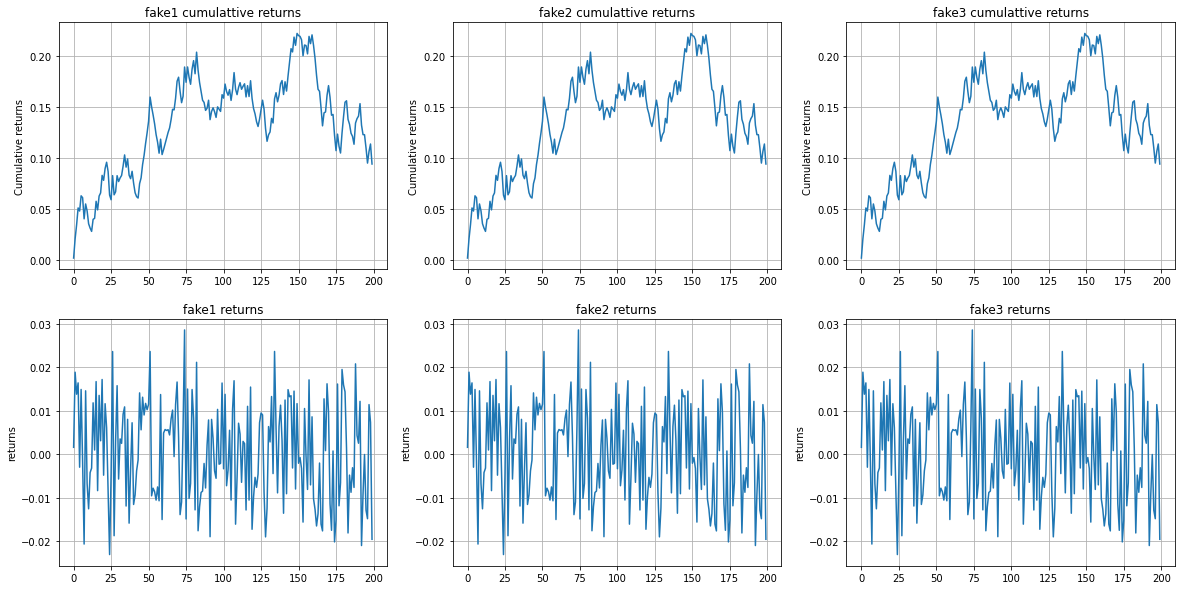

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

> on voit bien que lorsque que le vecteur de variables latentes est nul 

---

et que seul les biais sont prit en compte.Le réseau a au final appris du biais.Les trois series sont identiques ce qui est normale étant donné que le vecteur d'input est nul mais ce qui est interessant est de les comparer aux series obtenues precedement.En effet elles sont trés proches de celles obtenues avec en prenant des inputs non nuls ce qui laisse à penser que le biais est preponderant par rapport aux autres parametres apprient.

$\textit{En en conclut que le reseaux à essentiellement apprit du biais}$.

### Faits Stylisés

Dans cette question nous allons gennerer 1000 sries temporelles de taille T = 200 à l'aide du générateur précedement entrainé.





If $P(|r|) = |r|^{-\alpha - 1}$  , $P_{>}(|r|) = |r|^{-\alpha}$ ,
$log P_{>}(|r|) = cst-\alpha log|r|$.On trace en echelle log-log des Price returns . On doir avoir une pente $\alpha$ si les returns sont bien en loi de puissance.

In [ ]:
X_test , _ = generate_fake_samples( generator, latent_dim=40, n=1000 , bias_check = False ) 

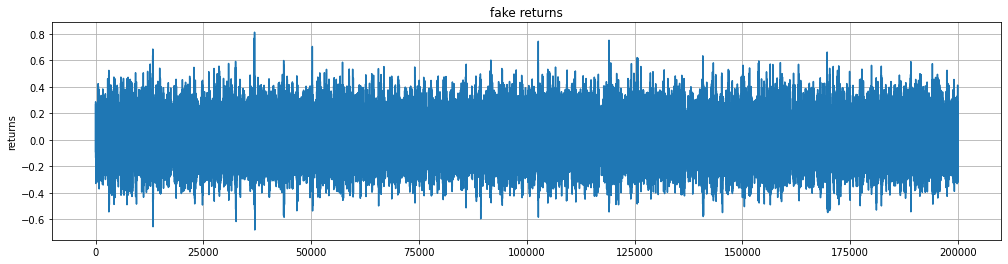

In [ ]:
fig, axs = plt.subplots(figsize = (17,4))
axs.plot(X_test.flatten())
axs.set_ylabel("returns")
axs.set_title("fake returns")
axs.grid()

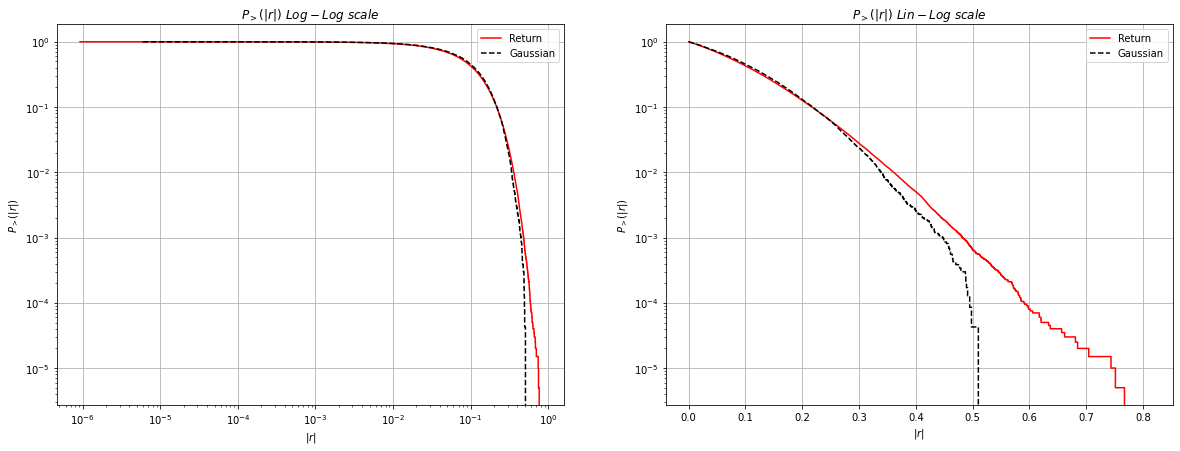

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# On trie les valeurs absolues distinctes des rendements
r_abs = np.unique(np.sort(np.abs(X_test.flatten())))
y = ECDF(r_abs) # On peut noter que la fonction ECDF trie directement les valeurs

                                        
np.random.seed(77)                           # moyenne des returns  # ecart-type des returns
lograndom_g = np.unique(np.sort(np.abs(np.random.normal(loc=X_test.flatten().mean(),scale=X_test.flatten().std(),size=Stock.shape[0])))) # On rescale sur 100 pour coller avec les rendements
Ecdf_g = ECDF(lograndom_g)

# On plot le graphique
fig, ax = plt.subplots(1,2,figsize = (20,7))
ax[0].set(title=r"$P_{>}(|r|) \ Log-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", xscale="log", yscale="log")
ax[0].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[0].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[0].legend() ; ax[0].grid() ; 
ax[1].set(title=r"$P_{>}(|r|) \ Lin-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", yscale="log")
ax[1].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[1].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[1].legend() ; ax[1].grid() ; 

> On oberve que sur le graphique log log les retruns devrait etre lineaire de coefficent $\alpha$ si ils suivaitent une loi de puissance , or on voit bien qu'ils ne suivent pas une loi de puisssance ( = absence de fat tails ) et de plus la courbe fit trés bien a celle d'une gaussienne.On en conclut que les fait stylisés observées sur les marchés ne sont pas bien répliqué.s

## II : Reseaux Denses Sans Biais:

* $\textbf{Objectif}$ : Nous avons montré précédement que le reseaux avait appris en grande partie du biais.Nous allosn chercher à entrainer le reseaux sans ce biais.

On fixe l'option "use_bias" à False pour le générateur et on entraine la même architécture de  GAN's utilisée dans la premiére partie.

In [ ]:
INIT_LR = 1e-5

# generate n real samples with class labels
def generate_real_samples(n):
  train = [] ; serie_size = 200 ; 
  for i in range(n):
    train.append(data[i:i+serie_size])
  X = np.array(train)
  y = ones((n, 1))
  return X, y 

def generate_latent_points(latent_dim=40, n=1000,bias_check = False):
  if bias_check == True:
    x_input = np.zeros(latent_dim*n)
  else :
    x_input = np.random.normal(0, 1, latent_dim*n)
  x_input = x_input.reshape(n, latent_dim)
  return x_input  ## generate a X_input of dim 1000*10

def generate_fake_samples(generator, latent_dim=40, n=1000,bias_check = False):
  x_input = generate_latent_points(latent_dim, n,bias_check)
  X = generator.predict(x_input)
  y = np.zeros((n,1))
  return X, y  ##  X de dim 1000*100


def create_generator(latent_space_dim=40, n_outputs=200):
  activ = 'relu'
  model = Sequential()
  model.add(Dense(40, activation = 'linear',use_bias=False,input_dim=latent_space_dim))
  model.add(Dropout(0.2))
  model.add(Dense(60, activation = activ,use_bias=False))
  model.add(Dropout(0.2))
  model.add(Dense(80, activation = activ,use_bias=False))
  model.add(Dropout(0.2))
  model.add(Dense(120, activation = activ,use_bias=False))
  model.add(Dropout(0.2))
  model.add(Dense(150, activation = activ,use_bias=False))
  model.add(Dropout(0.2))
  model.add(Dense(170, activation = activ,use_bias=False))
  model.add(Dense(n_outputs,activation='linear',use_bias=False))
  return model

def create_discriminator(intput_size=200):
  activ = 'tanh'
  model = Sequential()
  model.add(Dense(150, activation= activ,input_dim = intput_size))
  model.add(Dropout(0.2))
  model.add(Dense(100, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(20, activation = activ))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation = activ))
  model.add(Dense(1, activation ='sigmoid'))
  ganDisc = Adam(lr=INIT_LR*0.7, beta_1=0.5) 
  model.compile(loss='binary_crossentropy',optimizer=ganDisc,metrics=['accuracy'])
  return model

def create_gan(generator, discriminator):

  print("[INFO] building GAN...")
  discriminator.trainable = False
  ganInput = Input(shape=(40,))
  ganOutput = discriminator(generator(ganInput))
  gan = Model(ganInput, ganOutput)

  ganOpt = Adam(lr=1e-5, beta_1=0.5) 
  gan.compile(loss='binary_crossentropy',optimizer=ganOpt)
  return gan

def summarize_performances(epoch, generator, discriminator,latent_dim=150, n_points=100):
  X_real, y_real = generate_real_samples(n_points)
  X_fake, y_fake = generate_fake_samples(generator,
  latent_dim, n_points,bias_check = False)
  # on concatene X_real et X_gan
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  _, acc = discriminator.evaluate(X_GAN, Y_GAN)
  print('Epoch {}, Acc {}'.format(epoch,acc))
  

In [ ]:
# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator()
# create the gan
gan_model = create_gan(generator, discriminator)


latent_dim=40 ; n_epochs = 500 ;  n_batch=256 ; n_eval=10

for i in tqdm(range(n_epochs)):
  X_real, y_real = generate_real_samples(n_batch//2)
  X_fake, y_fake = generate_fake_samples(generator,
  latent_dim, n_batch//2,bias_check = False)
  # on concatene X_real et X_gan
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  (X_GAN,Y_GAN) = shuffle(X_GAN,Y_GAN)
  discriminator.train_on_batch(X_GAN,Y_GAN)
  x_gan = generate_latent_points(latent_dim, n_batch,bias_check = False)
  y_gan = np.ones((n_batch, 1))
  gan_model.train_on_batch(x_gan, y_gan)

  if (i % n_eval == 0):
    summarize_performances(i, generator,
    discriminator, latent_dim)



[INFO] building GAN...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


7/7 [==============================] - 0s 2ms/step - loss: 0.7032 - accuracy: 0.4350
Epoch 0, Acc 0.4350000023841858
7/7 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.4600
Epoch 10, Acc 0.46000000834465027
7/7 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.3750
Epoch 20, Acc 0.375
7/7 [==============================] - 0s 2ms/step - loss: 0.7193 - accuracy: 0.3950
Epoch 30, Acc 0.39500001072883606
7/7 [==============================] - 0s 2ms/step - loss: 0.7306 - accuracy: 0.3750
Epoch 40, Acc 0.375
7/7 [==============================] - 0s 2ms/step - loss: 0.7290 - accuracy: 0.4100
Epoch 50, Acc 0.4099999964237213
7/7 [==============================] - 0s 2ms/step - loss: 0.7358 - accuracy: 0.4000
Epoch 60, Acc 0.4000000059604645
7/7 [==============================] - 0s 2ms/step - loss: 0.7326 - accuracy: 0.4200
Epoch 70, Acc 0.41999998688697815
7/7 [==============================] - 0s 2ms/step - loss: 0.7461 - accuracy: 0.

In [ ]:
X_test , _ = generate_fake_samples(generator,latent_dim = 40,n=3)
data_plot = pd.DataFrame(data = { 'fake1' : X_test[0].cumsum().tolist() , 'fake2' : X_test[1].cumsum().tolist() , 'fake3' : X_test[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,0.027757,0.162410,0.088946
1,0.155730,0.290687,0.234967
2,0.175546,0.310566,0.229779
3,0.147144,0.257335,0.256221
4,0.040399,0.229751,0.260105
...,...,...,...
195,-0.571467,-0.009578,-1.517997
196,-0.660795,-0.226309,-1.859384
197,-0.641106,-0.195112,-1.958113
198,-0.680500,-0.281633,-1.964399


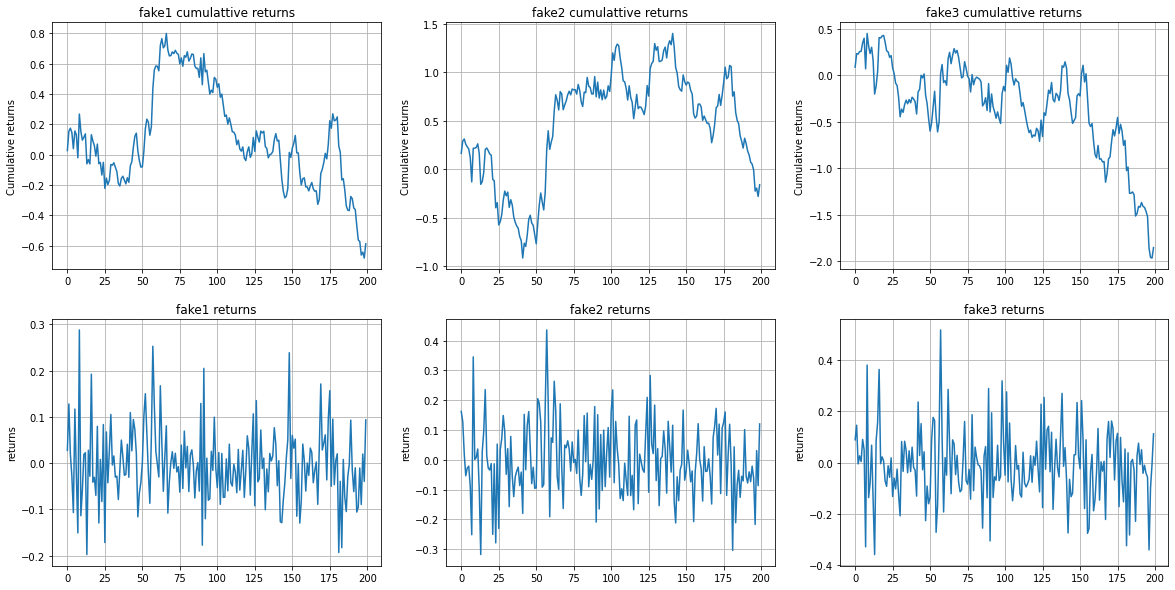

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

In [ ]:
X_test_bias , _ = generate_fake_samples(generator,latent_dim=40,n=3,bias_check=True)
data_plot = pd.DataFrame(data = { 'fake1' : X_test_bias[0].cumsum().tolist() , 'fake2' : X_test_bias[1].cumsum().tolist() , 'fake3' : X_test_bias[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
195,0.0,0.0,0.0
196,0.0,0.0,0.0
197,0.0,0.0,0.0
198,0.0,0.0,0.0


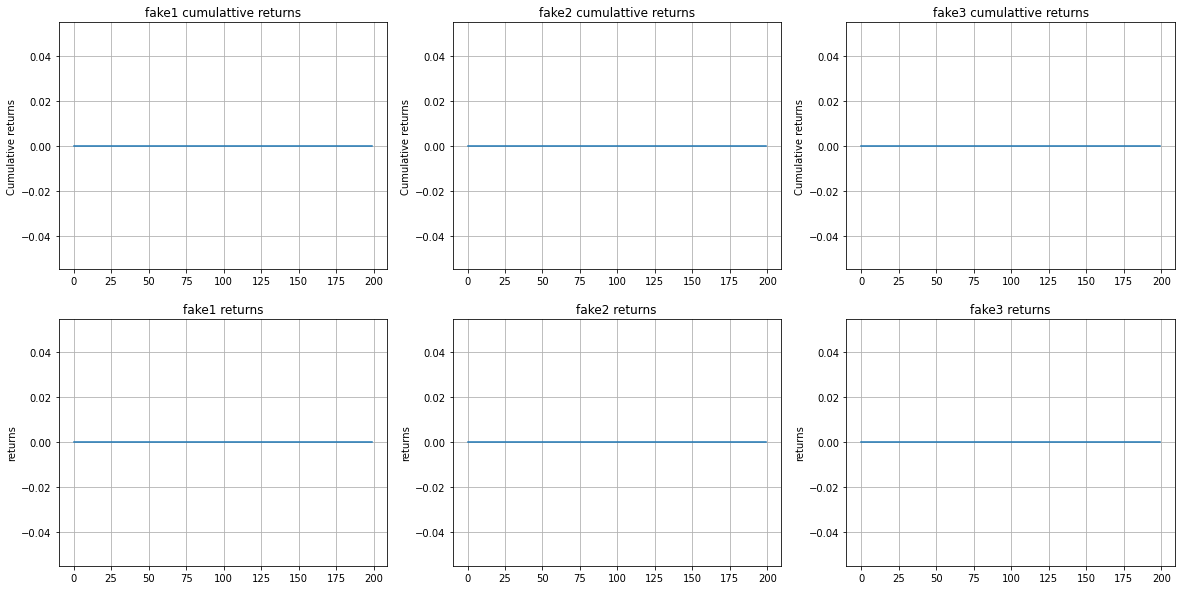

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test_bias[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test_bias[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test_bias[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

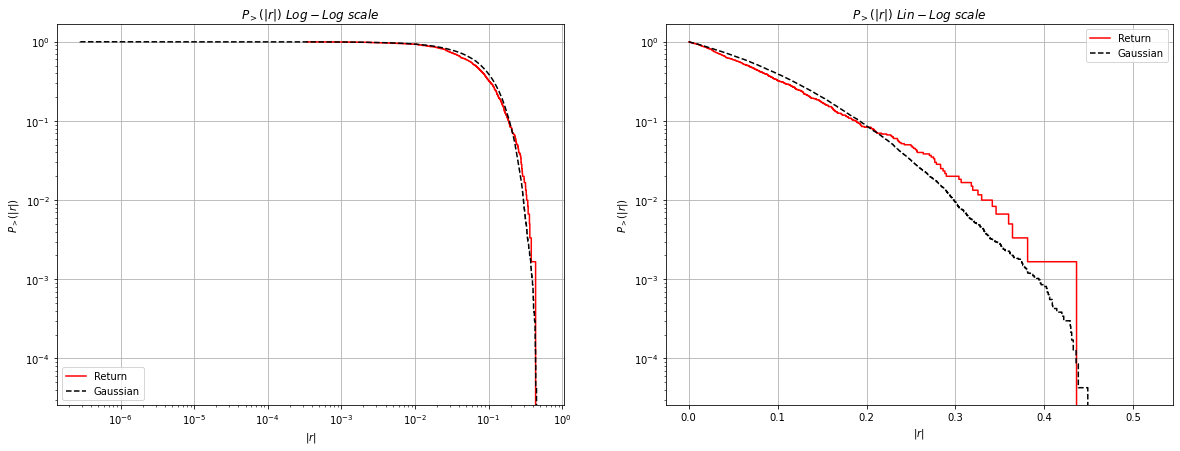

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# On trie les valeurs absolues distinctes des rendements
r_abs = np.unique(np.sort(np.abs(X_test.flatten())))
y = ECDF(r_abs) # On peut noter que la fonction ECDF trie directement les valeurs

                                        
np.random.seed(77)                           # moyenne des returns  # ecart-type des returns
lograndom_g = np.unique(np.sort(np.abs(np.random.normal(loc=X_test.flatten().mean(),scale=X_test.flatten().std(),size=Stock.shape[0])))) # On rescale sur 100 pour coller avec les rendements
Ecdf_g = ECDF(lograndom_g)

# On plot le graphique
fig, ax = plt.subplots(1,2,figsize = (20,7))
ax[0].set(title=r"$P_{>}(|r|) \ Log-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", xscale="log", yscale="log")
ax[0].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[0].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[0].legend() ; ax[0].grid() ; 
ax[1].set(title=r"$P_{>}(|r|) \ Lin-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", yscale="log")
ax[1].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[1].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[1].legend() ; ax[1].grid() ; 

## III / Génération de series à queux épaisses : GAN with GRU discriminator et generator . ( Non Concluant)


In [ ]:
from keras.layers import GRU , Reshape

In [ ]:
INIT_LR = 1e-5

# generate n real samples with class labels
def generate_real_samples(n):
  train = [] ; serie_size = 200 ; 
  for i in range(n):
    train.append(data[i:i+serie_size])
  X = np.array(train)
  y = ones((n, 1))
  return X, y 

def generate_latent_points(latent_dim=40, n=1000,bias_check = False):
  if bias_check == True:
    x_input = np.zeros(latent_dim*n)
  else :
    x_input = np.random.normal(0, 1, latent_dim*n)
  x_input = x_input.reshape(n,latent_dim,1)
  return x_input  ## generate a X_input of dim 1000*10

def generate_fake_samples(generator, latent_dim=40, n=1000,bias_check = False):
  x_input = generate_latent_points(latent_dim, n,bias_check)
  X = generator.predict(x_input)
  y = np.zeros((n,1))
  return X, y  ##  X de dim 1000*100


def create_generator(latent_space_dim=40, n_outputs=200):

  model = Sequential()
  model.add(GRU(40,input_shape = (40,1),return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(60,return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(80, return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(120, return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(150, return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(170, return_sequences=True,use_bias=False))
  model.add(Dropout(0.2))
  model.add(GRU(200, return_sequences=True,use_bias=False))
  model.add(GRU(n_outputs))
  model.add(Reshape((n_outputs,1)))
  return model

def create_discriminator(intput_size=200):
  activ = 'tanh'
  model = Sequential()
  model.add(GRU(200,input_shape = (200,1),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(GRU(100, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(GRU(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(GRU(20, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(GRU(5, return_sequences=True))
  model.add(GRU(1, activation ='sigmoid'))
  ganDisc = Adam(lr=INIT_LR*0.7, beta_1=0.5) 
  model.compile(loss='binary_crossentropy',optimizer=ganDisc,metrics=['accuracy'])
  return model

def create_gan(generator, discriminator):

  print("[INFO] building GAN...")
  discriminator.trainable = False
  ganInput = Input(shape=(40,1))
  ganOutput = discriminator(generator(ganInput))
  gan = Model(ganInput, ganOutput)

  ganOpt = Adam(lr=1e-5, beta_1=0.5) 
  gan.compile(loss='binary_crossentropy',optimizer=ganOpt)
  return gan

def summarize_performances(epoch, generator, discriminator,latent_dim=150, n_points=100):
  X_real, y_real = generate_real_samples(n_points)
  X_fake, y_fake = generate_fake_samples(generator,
  latent_dim, n_points,bias_check = False)
  # on concatene X_real et X_gan
  X_real = X_real.reshape((X_real.shape[0],X_real.shape[1],1))
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  X_GAN = X_GAN.reshape((X_GAN.shape[0],X_GAN.shape[1],1))
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  _, acc = discriminator.evaluate(X_GAN, Y_GAN)
  print('Epoch {}, Acc {}'.format(epoch,acc))
  

In [ ]:
# create the discriminator
discriminator = create_discriminator()
# create the generator
generator = create_generator()
# create the gan
gan_model = create_gan(generator, discriminator)


latent_dim=40 ; n_epochs = 200 ;  n_batch=256 ; n_eval=10

for i in tqdm(range(n_epochs)):
  X_real, y_real = generate_real_samples(n_batch//2)
  X_fake, y_fake = generate_fake_samples(generator,latent_dim, n_batch//2,bias_check = False)
  # on concatene X_real et X_gan
  X_real = X_real.reshape((X_real.shape[0],X_real.shape[1],1))
  X_GAN = np.concatenate((X_real,X_fake), axis=0)
  Y_GAN = np.concatenate((y_real,y_fake),axis =0)
  X_GAN = X_GAN.reshape((X_GAN.shape[0],X_GAN.shape[1],1))
  (X_GAN,Y_GAN) = shuffle(X_GAN,Y_GAN)
  discriminator.train_on_batch(X_GAN,Y_GAN)
  x_gan = generate_latent_points(latent_dim, n_batch,bias_check = False)
  y_gan = np.ones((n_batch, 1))
  gan_model.train_on_batch(x_gan,y_gan)

  if (i % n_eval == 0):
    summarize_performances(i, generator,
    discriminator, latent_dim)



[INFO] building GAN...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


7/7 [==============================] - 1s 39ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 0, Acc 0.5
7/7 [==============================] - 0s 39ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10, Acc 0.5
7/7 [==============================] - 0s 43ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 20, Acc 0.5
7/7 [==============================] - 0s 42ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 30, Acc 0.5
7/7 [==============================] - 0s 40ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 40, Acc 0.5
7/7 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 50, Acc 0.5
7/7 [==============================] - 0s 40ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 60, Acc 0.5
7/7 [==============================] - 0s 41ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 70, Acc 0.5
7/7 [==============================] - 0s 40ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 80, Acc 0.5
7/7 [==============================] - 0s 43ms/step - loss: 0.693

In [ ]:
X_test , _ = generate_fake_samples(generator,latent_dim=40,n=3)
data_plot = pd.DataFrame(data = { 'fake1' : X_test[0].cumsum().tolist() , 'fake2' : X_test[1].cumsum().tolist() , 'fake3' : X_test[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,-0.000188,0.000575,-0.000830
1,-0.001864,-0.000920,-0.001188
2,-0.002084,-0.000537,-0.000750
3,-0.004672,0.001179,-0.002592
4,-0.004592,0.001250,-0.003571
...,...,...,...
195,-0.027165,0.016188,0.003222
196,-0.026087,0.015976,0.005934
197,-0.024046,0.019448,0.008276
198,-0.021257,0.020871,0.010191


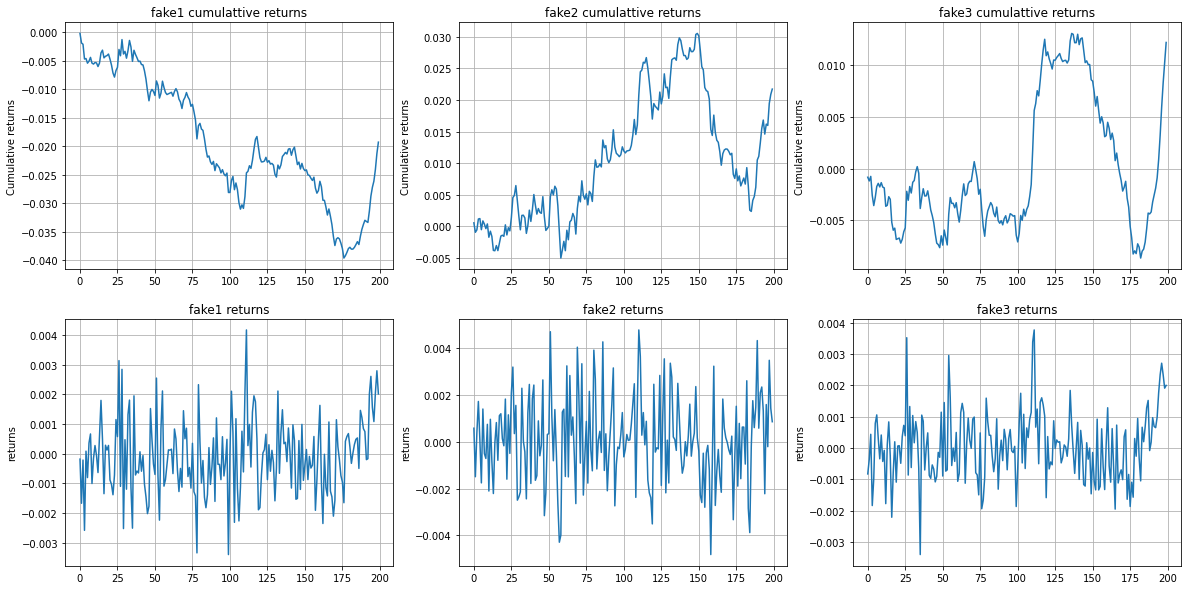

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

In [ ]:
X_test_bias , _ = generate_fake_samples(generator,latent_dim=40,n=3,bias_check=True)
data_plot = pd.DataFrame(data = { 'fake1' : X_test_bias[0].cumsum().tolist() , 'fake2' : X_test_bias[1].cumsum().tolist() , 'fake3' : X_test_bias[2].cumsum().tolist()} ,dtype=np.float)
data_plot

,fake1,fake2,fake3
0,-0.000577,-0.000577,-0.000577
1,-0.001348,-0.001348,-0.001348
2,-0.001135,-0.001135,-0.001135
3,-0.002010,-0.002010,-0.002010
4,-0.002888,-0.002888,-0.002888
...,...,...,...
195,0.003686,0.003686,0.003686
196,0.005458,0.005458,0.005458
197,0.007797,0.007797,0.007797
198,0.009827,0.009827,0.009827


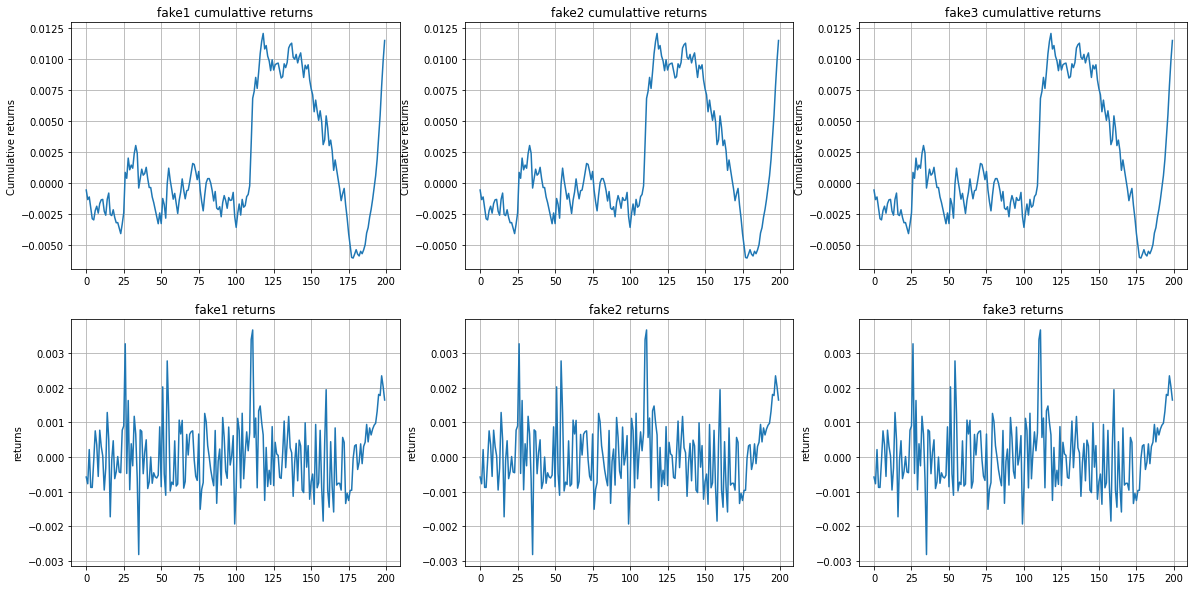

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (20,10))
axs[0,0].plot(data_plot.index,data_plot['fake1'].values) ; axs[0,0].set_ylabel("Cumulative returns")
axs[0,0].set_title("fake1 cumulattive returns"); axs[0,0].grid()
axs[0,1].plot(data_plot.index,data_plot['fake2'].values) ; axs[0,1].set_ylabel("Cumulative returns")
axs[0,1].set_title("fake2 cumulattive returns") ;axs[0,1].grid()
axs[0,2].plot(data_plot.index,data_plot['fake3'].values) ; axs[0,2].set_ylabel("Cumulative returns")
axs[0,2].set_title("fake3 cumulattive returns") ; axs[0,2].grid()
axs[1,0].plot(X_test_bias[0]) ; axs[1,0].set_ylabel("returns")
axs[1,0].set_title("fake1 returns") ; axs[1,0].grid()
axs[1,1].plot(X_test_bias[1]) ; axs[1,1].set_ylabel("returns")
axs[1,1].set_title("fake2 returns") ; axs[1,1].grid()
axs[1,2].plot(X_test_bias[2]) ; axs[1,2].set_ylabel("returns")
axs[1,2].set_title("fake3 returns") ; axs[1,2].grid()

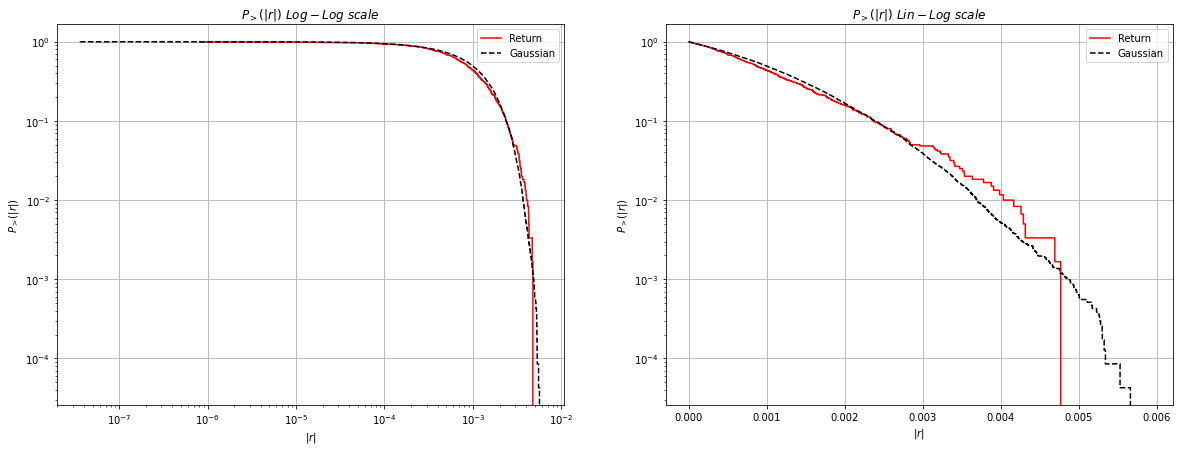

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# On trie les valeurs absolues distinctes des rendements
r_abs = np.unique(np.sort(np.abs(X_test.flatten())))
y = ECDF(r_abs) # On peut noter que la fonction ECDF trie directement les valeurs

                                        
np.random.seed(77)                           # moyenne des returns  # ecart-type des returns
lograndom_g = np.unique(np.sort(np.abs(np.random.normal(loc=X_test.flatten().mean(),scale=X_test.flatten().std(),size=Stock.shape[0])))) # On rescale sur 100 pour coller avec les rendements
Ecdf_g = ECDF(lograndom_g)

# On plot le graphique
fig, ax = plt.subplots(1,2,figsize = (20,7))
ax[0].set(title=r"$P_{>}(|r|) \ Log-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", xscale="log", yscale="log")
ax[0].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[0].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[0].legend() ; ax[0].grid() ; 
ax[1].set(title=r"$P_{>}(|r|) \ Lin-Log \ scale$", xlabel=f"$|r|$", ylabel="$P_{>}(|r|)$", yscale="log")
ax[1].step(r_abs, 1 - y(r_abs), label="Return", color="red")
ax[1].step(lograndom_g, 1 - Ecdf_g(lograndom_g), label="Gaussian", linestyle="--", color="black")
ax[1].legend() ; ax[1].grid() ; 

> Nous n'obtenons pas de queux grasses.